**Step 1. Import and read in json data to DataFrame**

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.patches import Arc, Rectangle, ConnectionPatch, Patch
from pandas.io.json import json_normalize
%matplotlib inline 

with open('./open-data/data/events/69199.json') as data_file:
    data = json.load(data_file)
df = json_normalize(data, sep = '_')

**Step 2. Use matplotlib patches to draw a pitch**

Pitch dimensions as mentioned from the StatsBomb documentation.
Reference: https://github.com/statsbomb/open-data/blob/master/doc/StatsBomb%20Event%20Data%20Specification%20v1.0.2.pdf

In [3]:
def draw_pitch(ax, colour = None, edge = 'black'):
    
    Background = Rectangle([-10,-10], width = 135, height = 95, fill = False)
    # Pitch Outline and Centre Line
    Pitch = Rectangle([0,0], width = 120, height = 80, edgecolor = edge, fill = False)
    
    if colour:
        Background = Rectangle([-10,-10], width = 135, height = 95, color = colour)
        # Pitch Outline and Centre Line
        Pitch = Rectangle([0,0], width = 120, height = 80, edgecolor = edge, facecolor = colour)
    
    # Left, Right Penalty Area and midline
    LeftPenalty = Rectangle([0,18], width = 18, height = 44, edgecolor = edge, fill = False)
    RightPenalty = Rectangle([102,18], width = 18, height = 44, edgecolor = edge, fill = False)
    midline = ConnectionPatch([60,0], [60,80], 'data', 'data', color = edge)
    
    # Left, Right 6-yard Box
    LeftSixYard = Rectangle([0,30], width = 6, height = 20, edgecolor = edge, fill = False)
    RightSixYard = Rectangle([114,30], width = 6, height = 20, edgecolor = edge, fill = False)
    
    #Goals
    LeftGoal = Rectangle([-3,36], width = 3, height = 8, linewidth = 1, edgecolor = 'black', fill = False)
    RightGoal = Rectangle([120,36], width = 3, height = 8, linewidth = 1, edgecolor = 'black', fill = False)
    
    # Prepare Circles
    centreCircle = plt.Circle((60,40), 8.1, color = edge, fill = False)
    centreSpot = plt.Circle((60,40), 0.71, color = edge)
    
    # Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((12,40), 0.71, color = edge)
    rightPenSpot = plt.Circle((108,40), 0.71, color = edge)
    leftArc = Arc((14, 40), height = 16.2, width = 16.2, angle = 0, theta1 = 300, theta2 = 60, color = edge)
    rightArc = Arc((106, 40), height = 16.2, width = 16.2, angle = 0, theta1 = 120, theta2 = 240, color = edge)
    
    element = [Background, Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc, LeftGoal, RightGoal]
    for i in element:
        ax.add_patch(i)

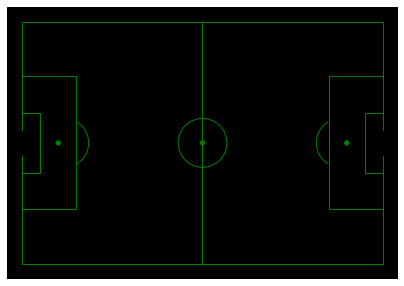

In [6]:
fig = plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1, 1, 1)
draw_pitch(ax, 'black', 'green')
plt.ylim(-5, 85)
plt.xlim(-5, 125)
plt.axis('off')
plt.show()

**Step 3. Heat maps**

Using seaborn library to create a smoothed out scatter plot of player locations to identify player presence, with the ability to overlay passes and shots.

In [15]:
def heat_pass_shot_map(ax, data, player_name, passes = False, shots = False, heatmap = False):
    shot_data = data[(data['type_name'] == 'Shot') & (data['player_name'] == player_name)]
    pass_data = data[(data['type_name'] == 'Pass') & (data['player_name'] == player_name)]
    action_data = data[(data['player_name'] == player_name)][:-1]
    
    ax.title.set_text(player_name)

    if heatmap:
        draw_pitch(ax)
    else:
        draw_pitch(ax, 'black', 'white')
    
    if passes:
        for i in range(len(pass_data)):
            # Differentiate different half by different colour
            color = 'blue' if pass_data.iloc[i]['period'] == 1 else 'red'
            ax.annotate('', xy = (pass_data.iloc[i]['pass_end_location'][0], pass_data.iloc[i]['pass_end_location'][1]), xycoords = 'data',
                xytext = (pass_data.iloc[i]['location'][0], pass_data.iloc[i]['location'][1]), textcoords = 'data',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color=color))
    
    if shots:
        for i in range(len(shot_data)):
            # Differentiate different half by different colour
            color = 'black' 
            if shot_data.iloc[i]['shot_outcome_name'] == 'Goal':
                color ='yellow'
            elif shot_data.iloc[i]['shot_outcome_name'] == 'Saved':
                color = 'purple'
            ax.annotate('', xy = (shot_data.iloc[i]['shot_end_location'][0], shot_data.iloc[i]['shot_end_location'][1]), xycoords = 'data',
                xytext = (shot_data.iloc[i]['location'][0], shot_data.iloc[i]['location'][1]), textcoords = 'data',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color=color))
    
    if heatmap:
        x_coord = [i[0] for i in action_data['location']]
        y_coord = [i[1] for i in action_data['location']]
        sns.kdeplot(x_coord, y_coord, shade = 'True', color = 'yellow', n_levels = 30, ax=ax)


Display the heatmap and passes for Midfielder Fran Kirby and Defender Millie Bright. We can see that many of the passes originate from the darker areas of the heatmap, as would be expected. Blue arrows represent passes in the first half of the game, red arrows represent passes in the second half.

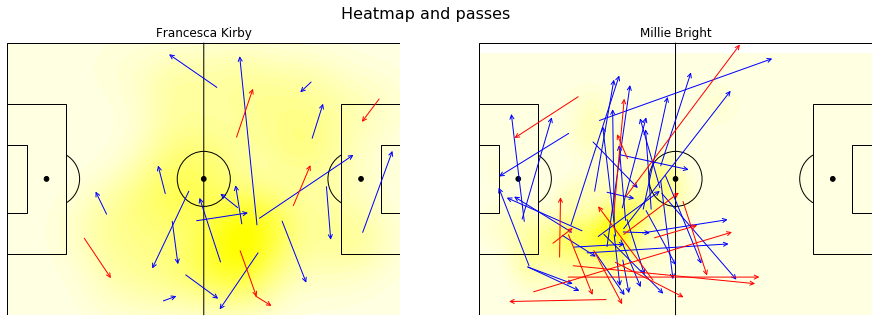

In [16]:
fig = plt.figure(edgecolor='yellow')
fig.set_size_inches(15.5, 5)
fig.suptitle('Heatmap and passes', fontsize=16)

ax1=fig.add_subplot(1, 2, 1)
ax2=fig.add_subplot(1, 2, 2)


heat_pass_shot_map(ax1, df, 'Francesca Kirby', passes = True, heatmap = True)
heat_pass_shot_map(ax2, df, 'Millie Bright', passes = True, heatmap = True)


ax1.set(ylim=(0, 80))
ax1.set(xlim=(0, 120))
ax1.axis('off')
ax2.set(ylim=(0, 80))
ax2.set(xlim=(0, 120))
ax2.axis('off')
plt.show()